# Week14 Cost & Autoscale Lab (Free/Local)

이 노트북은 14주차 **비용 최적화 & 오토스케일링** 실습을 위해 준비된 템플릿입니다.
- 외부 유료 API 없이 **로컬에서 토큰 비용을 추정**하고, **간단한 처리량 시뮬레이션**을 해봅니다.
- `tiktoken`이 설치되어 있으면 실제 인코더로 토큰을 계산하고, 없으면 **폴백 추정기**를 사용합니다.

## 실습 목표
1) 프롬프트 CSV를 읽어 **토큰수/요청당 비용/월간 비용** 추정
2) **캐시율/단가/요청량**을 바꾸며 시나리오 비교
3) 간단한 **처리량·지연 직관 시뮬레이션**으로 규모 추정 감 익히기


## 0) (선택) 패키지 설치 가이드
- 인터넷/권한이 허용되는 환경에서만 실행하세요.
- 이 노트북은 `pandas`, `matplotlib`만 필수이며, `tiktoken`이 있으면 정확도가 높아집니다.

```bash
pip install pandas matplotlib tiktoken --quiet
```


## 1) 라이브러리 임포트 및 토크나이저 준비

In [9]:
import math
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

ENC_NAME = "cl100k_base"  # 예: GPT-4/4o 계열

def get_tokenizer():
    try:
        import tiktoken
        enc = tiktoken.get_encoding(ENC_NAME)
        def _count(text: str) -> int:
            if text is None:
                text = ""
            return len(enc.encode(text))
        print(f"tiktoken 사용: {ENC_NAME}")
        return _count, True
    except Exception as e:
        print("tiktoken 미사용 — 폴백 추정기 사용(문자수/4)")
        def _fallback(text: str) -> int:
            if text is None:
                text = ""
            return max(1, math.ceil(len(text) / 4))
        return _fallback, False

count_tokens, USING_TIKTOKEN = get_tokenizer()


tiktoken 사용: cl100k_base


## 2) 파라미터 설정

In [12]:
PRICE_PER_1K = 0.002   # USD / 1K tokens (예시 단가)
CACHE_HIT    = 0.30     # 30% 캐시 히트 가정
DAILY_REQ    = 2000     # 하루 요청 수
DAYS_IN_MON  = 30       # 월 일수 가정

CSV_PATH = Path("prompts_week14.csv")


## 3) 샘플 CSV 생성 (없으면 생성)

In [13]:
if not CSV_PATH.exists():
    df_sample = pd.DataFrame([
        {"id": 1, "prompt": "뉴스 기사를 한 문장으로 요약해줘.", "expected_completion_len": 80},
        {"id": 2, "prompt": "아래 표를 분석해 핵심 인사이트 3가지를 bullet로 제시해줘.", "expected_completion_len": 120},
        {"id": 3, "prompt": "영화 리뷰 텍스트의 감정 분류 결과를 JSON으로 반환해줘.", "expected_completion_len": 60},
        {"id": 4, "prompt": "코드를 읽고 함수의 시간복잡도를 설명해줘.", "expected_completion_len": 150},
        {"id": 5, "prompt": "아래 회의록을 임원 보고서 요약 템플릿에 맞춰 정리해줘.", "expected_completion_len": 200},
    ])
    df_sample.to_csv(CSV_PATH, index=False)
    print(f"샘플 CSV 생성: {CSV_PATH}")
else:
    print(f"기존 CSV 사용: {CSV_PATH}")


샘플 CSV 생성: prompts_week14.csv


## 4) CSV 로드 및 토큰/비용 계산

In [14]:
df = pd.read_csv(CSV_PATH)

for col in ["id", "prompt", "expected_completion_len"]:
    if col not in df.columns:
        raise ValueError(f"CSV에 '{col}' 컬럼이 필요합니다.")

df["prompt_tok"] = df["prompt"].apply(lambda x: count_tokens(str(x)))
df["completion_tok"] = df["expected_completion_len"].fillna(0).astype(int)

df["cost"] = (df["prompt_tok"] + df["completion_tok"]) / 1000.0 * PRICE_PER_1K
df["eff_cost"] = df["cost"] * (1 - CACHE_HIT)

df


,id,prompt,expected_completion_len,prompt_tok,completion_tok,cost,eff_cost
0,1,뉴스 기사를 한 문장으로 요약해줘.,80,18,80,0.000196,0.000137
1,2,아래 표를 분석해 핵심 인사이트 3가지를 bullet로 제시해줘.,120,31,120,0.000302,0.000211
2,3,영화 리뷰 텍스트의 감정 분류 결과를 JSON으로 반환해줘.,60,26,60,0.000172,0.000120
3,4,코드를 읽고 함수의 시간복잡도를 설명해줘.,150,21,150,0.000342,0.000239
4,5,아래 회의록을 임원 보고서 요약 템플릿에 맞춰 정리해줘.,200,34,200,0.000468,0.000328


## 5) 요약 통계 및 월간 예산 추정

In [15]:
p50 = df["eff_cost"].quantile(0.5)
p95 = df["eff_cost"].quantile(0.95)
avg = df["eff_cost"].mean()

daily_cost   = avg * DAILY_REQ
monthly_cost = daily_cost * DAYS_IN_MON

print("=== Summary ===")
print(f"p50 per-req eff_cost: {p50:.6f} USD")
print(f"p95 per-req eff_cost: {p95:.6f} USD")
print(f"avg per-req eff_cost: {avg:.6f} USD")
print(f"Daily cost (@{DAILY_REQ} req/day): {daily_cost:.2f} USD")
print(f"Monthly cost (~{DAYS_IN_MON} days): {monthly_cost:.2f} USD")


=== Summary ===
p50 per-req eff_cost: 0.000211 USD
p95 per-req eff_cost: 0.000310 USD
avg per-req eff_cost: 0.000207 USD
Daily cost (@2000 req/day): 0.41 USD
Monthly cost (~30 days): 12.43 USD


## 6) 시각화: 비용 분포 / Top-N

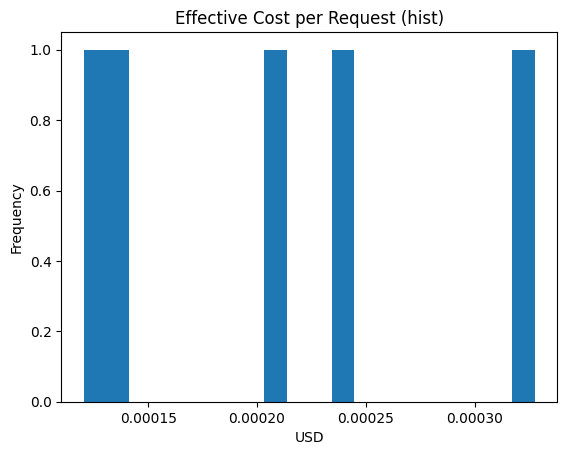

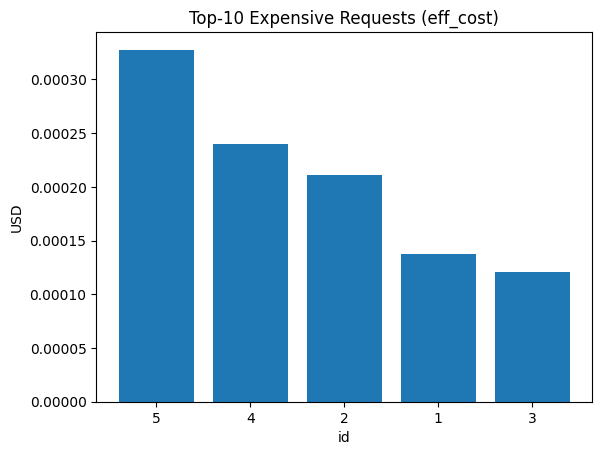

,id,prompt_tok,completion_tok,eff_cost
4,5,34,200,0.000328
3,4,21,150,0.000239
1,2,31,120,0.000211
0,1,18,80,0.000137
2,3,26,60,0.000120


In [16]:
plt.figure()
df["eff_cost"].plot(kind="hist", bins=20, title="Effective Cost per Request (hist)")
plt.xlabel("USD")
plt.show()

topn = df.sort_values("eff_cost", ascending=False).head(10)
plt.figure()
plt.bar(topn["id"].astype(str), topn["eff_cost"])
plt.title("Top-10 Expensive Requests (eff_cost)")
plt.xlabel("id")
plt.ylabel("USD")
plt.show()

topn[["id","prompt_tok","completion_tok","eff_cost"]]


## 7) What-if 시나리오: 단가/캐시율 변화

In [17]:
def scenario_cost(df_in: pd.DataFrame, price_per_1k: float, cache_hit: float):
    out = df_in.copy()
    out["cost"] = (out["prompt_tok"] + out["completion_tok"]) / 1000.0 * price_per_1k
    out["eff_cost"] = out["cost"] * (1 - cache_hit)
    return out

scenarios = [
    (0.002, 0.30, "base"),
    (0.002, 0.50, "cache50"),
    (0.0015, 0.30, "cheap_model"),
]

summary_rows = []
for price, cache, name in scenarios:
    tmp = scenario_cost(df, price, cache)
    avg_eff = tmp["eff_cost"].mean()
    monthly = avg_eff * DAILY_REQ * DAYS_IN_MON
    summary_rows.append({
        "scenario": name,
        "price_per_1k": price,
        "cache_hit": cache,
        "avg_eff_cost": avg_eff,
        "monthly_cost": monthly,
    })
pd.DataFrame(summary_rows)


,scenario,price_per_1k,cache_hit,avg_eff_cost,monthly_cost
0,base,0.0020,0.3,0.000207,12.432
1,cache50,0.0020,0.5,0.000148,8.880
2,cheap_model,0.0015,0.3,0.000155,9.324


## 8) 처리량/지연 직관 시뮬레이션 (간단)

In [18]:
λ, μ, c = 20, 3, 8   # 예시값: TPS=20, per-worker=3, workers=8
util = λ / (μ * c)
print("utilization (ρ):", round(util, 3))
if util >= 1:
    print("경고: ρ≥1 → 큐 폭증, 워커 증설/배치/캐시 필요")
else:
    print("ρ<1 → 평균적으로 안정. 버스트 대비 큐를 권장")


utilization (ρ): 0.833
ρ<1 → 평균적으로 안정. 버스트 대비 큐를 권장


## 9) 결과 저장 (CSV)

In [20]:
OUT_DIR = Path("week14_outputs")
OUT_DIR.mkdir(exist_ok=True, parents=True)

df_out = df.copy()
df_out.to_csv(OUT_DIR/"per_request_costs.csv", index=False)

import pandas as pd
pd.DataFrame(summary_rows).to_csv(OUT_DIR/"scenario_summary.csv", index=False)

print("저장 완료:")
print(OUT_DIR/"per_request_costs.csv")
print(OUT_DIR/"scenario_summary.csv")


저장 완료:
week14_outputs/per_request_costs.csv
week14_outputs/scenario_summary.csv


## 10) 다음 단계 (선택)
- CSV 내 프롬프트를 **요약/정규화**한 버전을 만들어 **토큰 절감 효과**를 비교해보세요.
- **스트리밍 on/off** 시 지연/체감 속도를 로그로 비교.
- RAG 캐시 유무 시나리오(동일 질의 반복)로 **캐시율에 따른 절감** 실험.
